# U-net:
Взял https://www.kaggle.com/takuok/keras-generator-starter-lb-0-326, но кол-во эпох поставил 100. Это дает 0.342. В нем не правильный рассчет целевой метрики, но вроде как-то коррелирует с LB. Если почините - поделитесь плз.

Я с ним еще немного игрался, но очевидные преобразования сети не дают прироста качества. Правда, нужно сначала нормально считать score, чтобы убедиться в этом наверняка

In [1]:
import cv2
import os
import numpy as np


def make_df(train_path, test_path, img_size):
    train_ids = next(os.walk(train_path))[1]
    test_ids = next(os.walk(test_path))[1]
    X_train = np.zeros((len(train_ids), img_size, img_size, 3), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), img_size, img_size, 1), dtype=np.bool)
    for i, id_ in enumerate(train_ids):
        path = train_path + id_
        img = cv2.imread(path + '/images/' + id_ + '.png')
        print(img.shape)
        img = cv2.resize(img, (img_size, img_size))
        X_train[i] = img
        mask = np.zeros((img_size, img_size, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = cv2.imread(path + '/masks/' + mask_file, 0)
            mask_ = cv2.resize(mask_, (img_size, img_size))
            mask_ = mask_[:, :, np.newaxis]
            mask = np.maximum(mask, mask_)
        Y_train[i] = mask
    X_test = np.zeros((len(test_ids), img_size, img_size, 3), dtype=np.uint8)
    sizes_test = []
    for i, id_ in enumerate(test_ids):
        path = test_path + id_
        img = cv2.imread(path + '/images/' + id_ + '.png')
        sizes_test.append([img.shape[0], img.shape[1]])
        img = cv2.resize(img, (img_size, img_size))
        X_test[i] = img

    return X_train, Y_train, X_test, sizes_test

Define Unet model.

In [4]:
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda


def Unet(img_size):
    inputs = Input((img_size, img_size, 3))
    s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

Using TensorFlow backend.


Define generator. Using keras ImageDataGenerator.
You can change the method of data augmentation by changing data_gen_args.

In [5]:
from keras.preprocessing.image import ImageDataGenerator

def generator(xtr, xval, ytr, yval, batch_size):
    data_gen_args = dict(horizontal_flip=True,
                         vertical_flip=True,
                         rotation_range=90.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.1)
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    image_datagen.fit(xtr, seed=7)
    mask_datagen.fit(ytr, seed=7)
    image_generator = image_datagen.flow(xtr, batch_size=batch_size, seed=7)
    mask_generator = mask_datagen.flow(ytr, batch_size=batch_size, seed=7)
    train_generator = zip(image_generator, mask_generator)

    val_gen_args = dict()
    image_datagen_val = ImageDataGenerator(**val_gen_args)
    mask_datagen_val = ImageDataGenerator(**val_gen_args)
    image_datagen_val.fit(xval, seed=7)
    mask_datagen_val.fit(yval, seed=7)
    image_generator_val = image_datagen_val.flow(xval, batch_size=batch_size, seed=7)
    mask_generator_val = mask_datagen_val.flow(yval, batch_size=batch_size, seed=7)
    val_generator = zip(image_generator_val, mask_generator_val)

    return train_generator, val_generator

Define metrics and loss function.

In [154]:
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.losses import binary_crossentropy


def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec))

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [155]:
from skimage.morphology import label

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [2]:
import cv2
import os
import pandas as pd
from sklearn.model_selection import train_test_split


img_size = 256
batch_size = 32
train_path = 'stage1_train/'
test_path = 'stage1_test/'

X_train, Y_train, X_test, sizes_test = make_df(train_path, test_path, img_size)
xtr, xval, ytr, yval = train_test_split(X_train, Y_train, test_size=0.1, random_state=7)
train_generator, val_generator = generator(xtr, xval, ytr, yval, batch_size)

model = Unet(img_size)
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[mean_iou])

model.fit_generator(train_generator, steps_per_epoch=len(xtr)/6, epochs=100,
                    validation_data=val_generator, validation_steps=len(xval)/batch_size)

preds_test = model.predict(X_test, verbose=1)

preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(cv2.resize(preds_test[i], 
                                       (sizes_test[i][1], sizes_test[i][0])))

test_ids = next(os.walk(test_path))[1]
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub.csv', index=False)

# Эксперименты с тем, как из 3-х слоев изображения сделать 2 
Пока не пригодилось, но хочу подавать 2 первых канала, а 3-м подавать предсказания U-Net'a

В обсуждения писали, что зеленый канал - самый важный, так что решил выкидывать синий

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
x = X_train[2, :, :, :].copy()
x[:, :, 1] = x[:, :, 2]
plt.imshow(x)

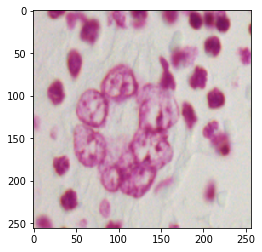

In [39]:
plt.imshow(X_train[2, :, :, :])

In [50]:
x[:, :, 0] = x[:, :, 2]

In [52]:
import skimage

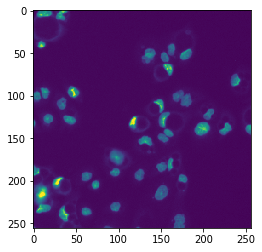

In [55]:
plt.imshow(skimage.color.rgb2gray(X_train[0, :, :, :]))

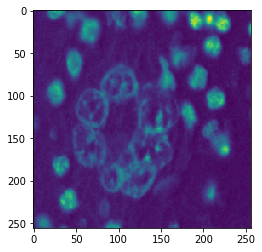

In [58]:
plt.imshow(1 /skimage.color.rgb2gray(x))

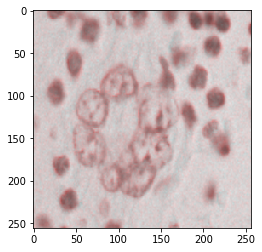

In [51]:
plt.imshow(x)

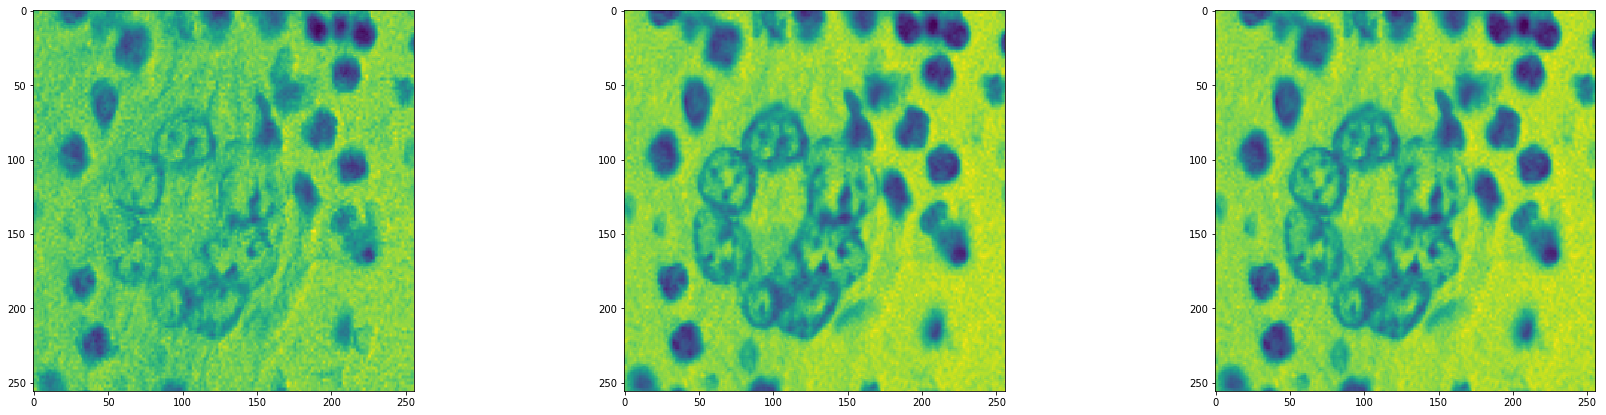

In [35]:
plt.figure(figsize=(30,7))
plt.subplot(1,3,1)
plt.imshow(x[:, :, 0])
plt.subplot(1,3,2)
plt.imshow(x[:, :, 1])
plt.subplot(1,3,3)
plt.imshow(x[:, :, 2])

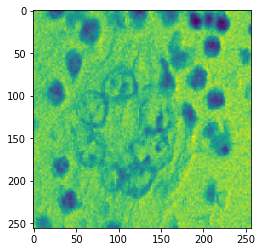

In [27]:
plt.imshow(X_train[2, :, :, 0])

# MASK-RCNN
https://github.com/matterport/Mask_RCNN

In [1]:

import cv2
import os
import pandas as pd
from sklearn.model_selection import train_test_split

from os import listdir, path
import sys, os
sys.path.insert(0, '../Mask_RCNN')


import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
import visualize

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


## Я проставлял параметры почти из головы, начитавшись кернелов с обзорами датасета. Скорее всего, это не самые оптимальные параметры:

In [8]:
import math

import utils
from PIL import Image
from config import Config

class KernelsDataset(utils.Dataset):
    def __init__(self, root, images_ids):
        super(KernelsDataset, self).__init__()
        
        self.root = root
        self.add_class("kernel", 1, 'kernel')
        
        self.image_id2index = {}
        self.index2image_id = {}

        for index, image_id in enumerate(images_ids):
            self.image_id2index[image_id] = index
            self.index2image_id[index] = image_id
            self.add_image("kernel", index, path.join(self.root, image_id, 'images', image_id + '.png'))
            
    
    def load_mask(self, image_index):
        masks_dir = path.join(path.join(self.root, self.index2image_id[image_index], 'masks'))
        masks = []
        
        for i, mask_name in enumerate(listdir(masks_dir)):
            mask_path = path.join(masks_dir, mask_name)
            mask = np.array(Image.open(mask_path))
#             if i == 0:
#                 mask_bg = np.zeros_like(mask, dtype=np.uint8)
#                 masks.append(mask_bg)
            masks.append(mask)
        masks = np.array(masks)    
        masks = np.transpose(masks, (1, 2, 0))
        return masks.astype(np.uint8), np.ones(masks.shape[2], np.uint8)
    
    def load_image(self, image_index):
        img = Image.open(self.image_info[image_index]['path'])
        img = img.convert('RGB')
        img = np.array(img)
        return img

class KernelsConfig(Config):
    """Base configuration class. For custom configurations, create a
    sub-class that inherits from this one and override properties
    that need to be changed.
    """
    # Name the configurations. For example, 'COCO', 'Experiment 3', ...etc.
    # Useful if your code needs to do things differently depending on which
    # experiment is running.
    NAME = 'kernels'  # Override in sub-classes

    # NUMBER OF GPUs to use. For CPU training, use 1
    GPU_COUNT = 1

    # Number of images to train with on each GPU. A 12GB GPU can typically
    # handle 2 images of 1024x1024px.
    # Adjust based on your GPU memory and image sizes. Use the highest
    # number that your GPU can handle for best performance.
    IMAGES_PER_GPU = 1

    # Number of training steps per epoch
    # This doesn't need to match the size of the training set. Tensorboard
    # updates are saved at the end of each epoch, so setting this to a
    # smaller number means getting more frequent TensorBoard updates.
    # Validation stats are also calculated at each epoch end and they
    # might take a while, so don't set this too small to avoid spending
    # a lot of time on validation stats.
    STEPS_PER_EPOCH = 300

    # Number of validation steps to run at the end of every training epoch.
    # A bigger number improves accuracy of validation stats, but slows
    # down the training.
    VALIDATION_STEPS = 25

    # The strides of each layer of the FPN Pyramid. These values
    # are based on a Resnet101 backbone.
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]

    # Number of classification classes (including background)
    NUM_CLASSES = 1 + 1  # Override in sub-classes

    ###### RPN ######
    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)

    # Ratios of anchors at each cell (width/height)
    # A value of 1 represents a square anchor, and 0.5 is a wide anchor
    RPN_ANCHOR_RATIOS = [0.25, 0.5, 1, 2, 4]

    # Anchor stride
    # If 1 then anchors are created for each cell in the backbone feature map.
    # If 2, then anchors are created for every other cell, and so on.
    RPN_ANCHOR_STRIDE = 2

    # How many anchors per image to use for RPN training
#     RPN_TRAIN_ANCHORS_PER_IMAGE = 375

    # ROIs kept after non-maximum supression (training and inference)
#     POST_NMS_ROIS_TRAINING = 2000
#     POST_NMS_ROIS_INFERENCE = 1000

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Input image resing
    # Images are resized such that the smallest side is >= IMAGE_MIN_DIM and
    # the longest side is <= IMAGE_MAX_DIM. In case both conditions can't
    # be satisfied together the IMAGE_MAX_DIM is enforced.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256#1024 #1388
    # If True, pad images with zeros such that they're (max_dim by max_dim)
    IMAGE_PADDING = True  # currently, the False option is not supported

    # Image mean (RGB)
    MEAN_PIXEL = (150.46, 118.85, 95.81)

    # Number of ROIs per image to feed to classifier/mask heads
    TRAIN_ROIS_PER_IMAGE = 512  # TODO: paper uses 512

    # Percent of positive ROIs used to train classifier/mask heads
    ROI_POSITIVE_RATIO = 0.33

    # Pooled ROIs
    POOL_SIZE = 7
    MASK_POOL_SIZE = 14
    MASK_SHAPE = [28, 28]

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 375

    # Bounding box refinement standard deviation for RPN and final detections.
    RPN_BBOX_STD_DEV = np.array([0.1, 0.1, 0.2, 0.2])
    BBOX_STD_DEV = np.array([0.1, 0.1, 0.2, 0.2])

    # Max number of final detections
    DETECTION_MAX_INSTANCES = 375

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.5

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3

    # Learning rate and momentum
    # The paper uses lr=0.02, but we found that to cause weights to explode often
    LEARNING_RATE = 0.002
    LEARNING_MOMENTUM = 0.9

    # Weight decay regularization
    WEIGHT_DECAY = 0.0001

    # Use RPN ROIs or externally generated ROIs for training
    # Keep this True for most situations. Set to False if you want to train
    # the head branches on ROI generated by code rather than the ROIs from
    # the RPN. For example, to debug the classifier head without having to
    # train the RPN.
    USE_RPN_ROIS = True

    
    def __init__(self):
        """Set values of computed attributes."""
        # Effective batch size
        self.BATCH_SIZE = self.IMAGES_PER_GPU * self.GPU_COUNT

        # Input image size
        self.IMAGE_SHAPE = np.array(
            [self.IMAGE_MAX_DIM, self.IMAGE_MAX_DIM, 3])

        # Compute backbone size from input image size
        self.BACKBONE_SHAPES = np.array(
            [[int(math.ceil(self.IMAGE_SHAPE[0] / stride)),
              int(math.ceil(self.IMAGE_SHAPE[1] / stride))]
             for stride in self.BACKBONE_STRIDES])

    def display(self):
        """Display Configuration values."""
        print("\nConfigurations:")
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)):
                print("{:30} {}".format(a, getattr(self, a)))
        print("\n")

train_imgs_dir = 'stage1_train'
train_ids = [f for f in listdir(train_imgs_dir) if path.isdir(path.join(train_imgs_dir, f))]
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=42)

dataset_train = KernelsDataset(train_imgs_dir, train_ids)
dataset_train.prepare()

dataset_val = KernelsDataset(train_imgs_dir, val_ids)
dataset_val.prepare()

test_imgs_dir = 'stage1_test'
test_ids = [f for f in listdir(test_imgs_dir) if path.isdir(path.join(test_imgs_dir, f))]
dataset_test = KernelsDataset(test_imgs_dir, test_ids)
dataset_val.prepare()


config = KernelsConfig()

ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169


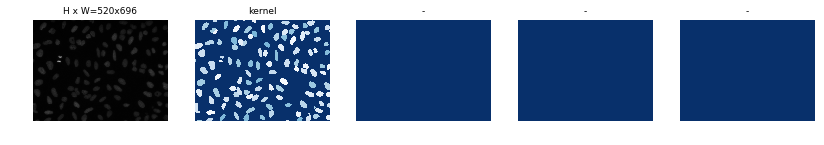

e856511ac1c34d24320eb7c56c05a4a3340d06667b4f5b8e8df615d415c7f650


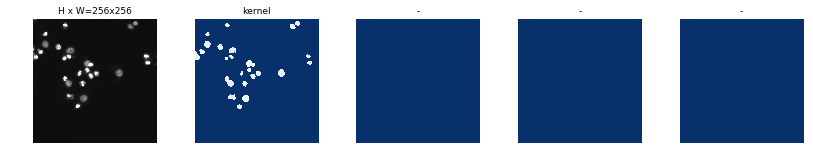

317832f90f02c5e916b2ac0f3bcb8da9928d8e400b747b2c68e544e56adacf6b


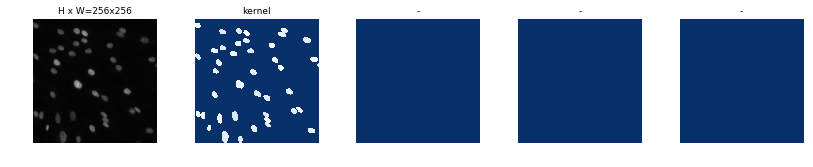

In [3]:
import visualize

image_ids = train_ids[:3]
for image_id in image_ids:
    print(image_id)
    image = dataset_train.load_image(dataset_train.image_id2index[image_id])
    mask, class_ids = dataset_train.load_mask(dataset_train.image_id2index[image_id])
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

#### У меня почему-то не завелась инициализация через coco, которая стоит по умолчанию. Если у вас заведется - напишите, как вы этого добились:

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "imagenet" #, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

In [1]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [10]:
class InferenceConfig(KernelsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/i.slinko/projects/kaggle_datascience_bowl_2018/logs/kernels20180127T1858/mask_rcnn_kernels_0002.h5


(256, 256, 3)


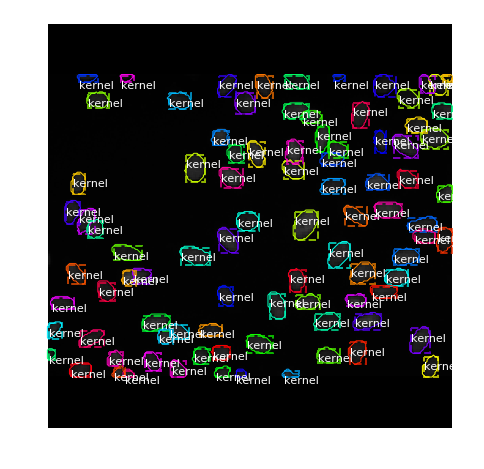

In [128]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

# print("original_image", original_image)
# print("image_meta", image_meta)
# log("gt_class_id", gt_class_id) 
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

print(original_image.shape)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

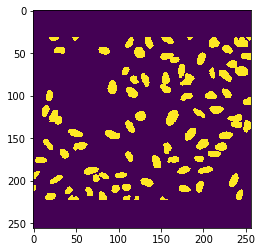

In [129]:
plt.imshow(np.sum(gt_mask[:,:], axis=2))

In [111]:
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

/home/i.slinko/miniconda/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


mAP:  0.564757630378


In [133]:
results = model.detect([original_image], verbose=1)

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:   68.00000
molded_images            shape: (1, 256, 256, 3)      min: -150.46000  max:  -27.81000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


In [166]:
def image_id2rle(image_id):
    image_index = dataset_test.image_id2index[image_id]
    mask_sum = None
    img_size = Image.open(dataset_test.image_info[image_index]['path']).size

    for mask_index in range(results[0]['masks'].shape[2]):
        mask_image = np.array(Image.fromarray(results[0]['masks'][:,:,mask_index]).resize(img_size))
        if mask_sum is None:
            mask_sum = mask_image
        else:
            mask_image[np.where(mask_sum + mask_image > 1)] = 0
            mask_sum += mask_image
        yield rle_encoding(mask_image)

In [167]:
test_path = 'stage1_test/'
test_ids = next(os.walk(test_path))[1]
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(image_id2rle(id_))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub.csv', index=False)

#### Засылание sub.csv на LB дает score 0. Если удастся пофиксить, пришлите правильную версию